## JWST F770W Mosaic 2 Tile Simulation Data Reduction

M101 as the target.  Using IRAC 8 micron scaled to look like it was observed with JWST (pixel size scaled by 0.8/6.5)

Based on excellent JWebbinar image data reduction notebooks authored by B. Hilbert

In [1]:
# Packages that allow us to get information about objects:
import asdf
import copy
import os
import shutil
import glob

# Numpy library:
import numpy as np

# For downloading data
import requests

# Astropy tools:
from astropy.io import ascii, fits
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch
from astropy.visualization import simple_norm

In [2]:
import astropy
print(astropy.__version__)

5.0


In [3]:
os.environ["CRDS_PATH"] = "/home/kgordon/crds_cache"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid

# Use this version for non-interactive plots (easier scrolling of the notebook)
%matplotlib inline

# Use this version (outside of Jupyter Lab) if you want interactive plots
#%matplotlib notebook

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

In [5]:
# List of possible data quality flags
from jwst.datamodels import dqflags

# entire pipelines pipeline
from jwst.pipeline import calwebb_detector1
from jwst.pipeline import calwebb_image2
from jwst.pipeline import calwebb_image3

# Individual steps that make up calwebb_detector1
from jwst.dq_init import DQInitStep
from jwst.saturation import SaturationStep
from jwst.superbias import SuperBiasStep
from jwst.ipc import IPCStep                                                                                    
from jwst.refpix import RefPixStep                                                                
from jwst.linearity import LinearityStep
from jwst.persistence import PersistenceStep
from jwst.dark_current import DarkCurrentStep
from jwst.jump import JumpStep
from jwst.ramp_fitting import RampFitStep
from jwst import datamodels

from jwst.associations import asn_from_list
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base

In [6]:
import jwst
print(jwst.__version__)

1.4.3


In [7]:
def show_image(data_2d, vmin, vmax, xpixel=None, ypixel=None, title=None):
    """Function to generate a 2D, log-scaled image of the data, 
    with an option to highlight a specific pixel (with a red dot).
    
    Parameters
    ----------
    data_2d : numpy.ndarray
        Image to be displayed
        
    vmin : float
        Minimum signal value to use for scaling
        
    vmax : float
        Maximum signal value to use for scaling
        
    xpixel : int
        X-coordinate of pixel to highlight
        
    ypixel : int
        Y-coordinate of pixel to highlight
        
    title : str
        String to use for the plot title
    """
    norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                          stretch=LogStretch())
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(data_2d, origin='lower', norm=norm)
    
    if xpixel and ypixel:
        plt.plot(xpixel, ypixel, marker='o', color='red', label='Selected Pixel')

    fig.colorbar(im, label='DN')
    plt.xlabel('Pixel column')
    plt.ylabel('Pixel row')
    if title:
        plt.title(title)

In [8]:
def overlay_catalog(data_2d, catalog, flux_limit=0, vmin=0, vmax=10,
                    title=None, units='MJy/str'):
    """Function to generate a 2D image of the data, 
    with sources overlaid.
    
    data_2d : numpy.ndarray
        2D image to be displayed
        
    catalog : astropy.table.Table
        Table of sources
    
    flux_limit : float
        Minimum signal threshold to overplot sources from catalog.
        Sources below this limit will not be shown on the image.
        
    vmin : float
        Minimum signal value to use for scaling
        
    vmax : float
        Maximum signal value to use for scaling
        
    title : str
        String to use for the plot title
                
    units : str
        Units of the data. Used for the annotation in the
        color bar
    """
    norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=LogStretch())
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(data_2d, origin='lower', norm=norm)
    
    for row in catalog:
        if row['aper_total_flux'].value > flux_limit:
            plt.plot(row['xcentroid'], row['ycentroid'], marker='o',
                     markersize='3', color='red')

    plt.xlabel('Pixel column')
    plt.ylabel('Pixel row')
    
    fig.colorbar(im, label=units)
    fig.tight_layout()
    plt.subplots_adjust(left=0.15)
    
    if title:
        plt.title(title)

## Overall

In [9]:
filter = "F770W"

## CALWEBB_DETECTOR1

In [10]:
miri_uncal_files = glob.glob(f"./stage0/*{filter}exp1.fits")
output_dir = './stage1'
print(miri_uncal_files)

['./stage0/det_image_seq1_MIRIMAGE_F770Wexp1.fits', './stage0/det_image_seq2_MIRIMAGE_F770Wexp1.fits', './stage0/det_image_seq3_MIRIMAGE_F770Wexp1.fits', './stage0/det_image_seq4_MIRIMAGE_F770Wexp1.fits']


In [11]:
for miri_uncal_file in miri_uncal_files:
    print(miri_uncal_file)

    # Using the run() method:
    # Instantiate the pipeline
    miri1 = calwebb_detector1.Detector1Pipeline()

    # Save the final output of the pipeline
    miri1.output_dir = output_dir
    miri1.save_results = True

    # Save the output from the jump detecion step,
    # and let's use a more stringent limit for cosmic ray
    # detection
    miri1.jump.save_results = True
    miri1.jump.rejection_threshold = 3

    # The dark current file used to create the simulated data
    # is much different and cleaner than that used in the pipeline,
    # so let's turn off the dark subtraction step in order to end up
    # with a cleaner rate image.
    miri1.dark_current.skip = True

    # Call the run() method
    miri_output = miri1.run(miri_uncal_file)


./stage0/det_image_seq1_MIRIMAGE_F770Wexp1.fits


2022-03-14 14:05:50,501 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2022-03-14 14:05:50,504 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2022-03-14 14:05:50,507 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2022-03-14 14:05:50,510 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-03-14 14:05:50,513 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-03-14 14:05:50,516 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2022-03-14 14:05:50,519 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2022-03-14 14:05:50,522 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2022-03-14 14:05:50,525 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2022-03-14 14:05:50,527 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2022-03-14 1

2022-03-14 14:05:52,990 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2022-03-14 14:05:52,991 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_reset_0047.fits'.
2022-03-14 14:05:52,992 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits'.
2022-03-14 14:05:52,993 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits'.
2022-03-14 14:05:52,994 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2022-03-14 14:05:52,995 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2022-03-14 14:05:52,996 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2022-03-14 14:05:52,997 - stpipe.Detector1Pipe

2022-03-14 14:05:56,695 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2022-03-14 14:05:56,812 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 1024, 1032) from det_image_seq1_MIRIMAGE_F770Wexp1.fits>,).
2022-03-14 14:05:56,817 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage1', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './stage0', 'dark_output': None}
2022-03-14 14:05:56,819 - stpipe.Detector1Pipeline.dark_current - INFO - Step skipped.
2022-03-14 14:05:56,825 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2022-03-14 14:05:56,946 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 1024, 1032) from det_image_seq1_MIRIMAGE_F

2022-03-14 14:06:02,245 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


./stage0/det_image_seq2_MIRIMAGE_F770Wexp1.fits


2022-03-14 14:06:02,267 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2022-03-14 14:06:02,270 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2022-03-14 14:06:02,273 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2022-03-14 14:06:02,277 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-03-14 14:06:02,281 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-03-14 14:06:02,285 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2022-03-14 14:06:02,288 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2022-03-14 14:06:02,290 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2022-03-14 14:06:02,294 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2022-03-14 14:06:02,297 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2022-03-14 1

2022-03-14 14:06:02,596 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2022-03-14 14:06:02,597 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_reset_0047.fits'.
2022-03-14 14:06:02,599 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits'.
2022-03-14 14:06:02,600 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits'.
2022-03-14 14:06:02,601 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2022-03-14 14:06:02,602 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2022-03-14 14:06:02,603 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2022-03-14 14:06:02,605 - stpipe.Detector1Pipe

2022-03-14 14:06:06,181 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2022-03-14 14:06:06,301 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 1024, 1032) from det_image_seq2_MIRIMAGE_F770Wexp1.fits>,).
2022-03-14 14:06:06,305 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage1', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './stage0', 'dark_output': None}
2022-03-14 14:06:06,308 - stpipe.Detector1Pipeline.dark_current - INFO - Step skipped.
2022-03-14 14:06:06,315 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2022-03-14 14:06:06,438 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 1024, 1032) from det_image_seq2_MIRIMAGE_F

2022-03-14 14:06:11,603 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


./stage0/det_image_seq3_MIRIMAGE_F770Wexp1.fits


2022-03-14 14:06:11,623 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2022-03-14 14:06:11,626 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2022-03-14 14:06:11,629 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2022-03-14 14:06:11,631 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-03-14 14:06:11,634 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-03-14 14:06:11,637 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2022-03-14 14:06:11,640 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2022-03-14 14:06:11,643 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2022-03-14 14:06:11,646 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2022-03-14 14:06:11,649 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2022-03-14 1

2022-03-14 14:06:11,953 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2022-03-14 14:06:11,954 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_reset_0047.fits'.
2022-03-14 14:06:11,956 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits'.
2022-03-14 14:06:11,957 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits'.
2022-03-14 14:06:11,958 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2022-03-14 14:06:11,959 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2022-03-14 14:06:11,960 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2022-03-14 14:06:11,962 - stpipe.Detector1Pipe

2022-03-14 14:06:15,496 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2022-03-14 14:06:15,617 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 1024, 1032) from det_image_seq3_MIRIMAGE_F770Wexp1.fits>,).
2022-03-14 14:06:15,621 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage1', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './stage0', 'dark_output': None}
2022-03-14 14:06:15,623 - stpipe.Detector1Pipeline.dark_current - INFO - Step skipped.
2022-03-14 14:06:15,630 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2022-03-14 14:06:15,756 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 1024, 1032) from det_image_seq3_MIRIMAGE_F

2022-03-14 14:06:20,880 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


./stage0/det_image_seq4_MIRIMAGE_F770Wexp1.fits


2022-03-14 14:06:20,899 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2022-03-14 14:06:20,902 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2022-03-14 14:06:20,904 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2022-03-14 14:06:20,907 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2022-03-14 14:06:20,910 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2022-03-14 14:06:20,914 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2022-03-14 14:06:20,918 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2022-03-14 14:06:20,921 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2022-03-14 14:06:20,924 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2022-03-14 14:06:20,927 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2022-03-14 1

2022-03-14 14:06:21,226 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2022-03-14 14:06:21,227 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_reset_0047.fits'.
2022-03-14 14:06:21,228 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_rscd_0010.fits'.
2022-03-14 14:06:21,229 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/kgordon/crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits'.
2022-03-14 14:06:21,230 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2022-03-14 14:06:21,232 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.
2022-03-14 14:06:21,233 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.
2022-03-14 14:06:21,234 - stpipe.Detector1Pipe

2022-03-14 14:06:24,748 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2022-03-14 14:06:24,869 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 5, 1024, 1032) from det_image_seq4_MIRIMAGE_F770Wexp1.fits>,).
2022-03-14 14:06:24,873 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './stage1', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': './stage0', 'dark_output': None}
2022-03-14 14:06:24,875 - stpipe.Detector1Pipeline.dark_current - INFO - Step skipped.
2022-03-14 14:06:24,880 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2022-03-14 14:06:25,000 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 5, 1024, 1032) from det_image_seq4_MIRIMAGE_F

2022-03-14 14:06:30,069 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


In [12]:
# look at one of the images
miri_rate_files = glob.glob(f"./stage1/*{filter}exp1_rate.fits")
miri_rate = datamodels.open(miri_rate_files[0])

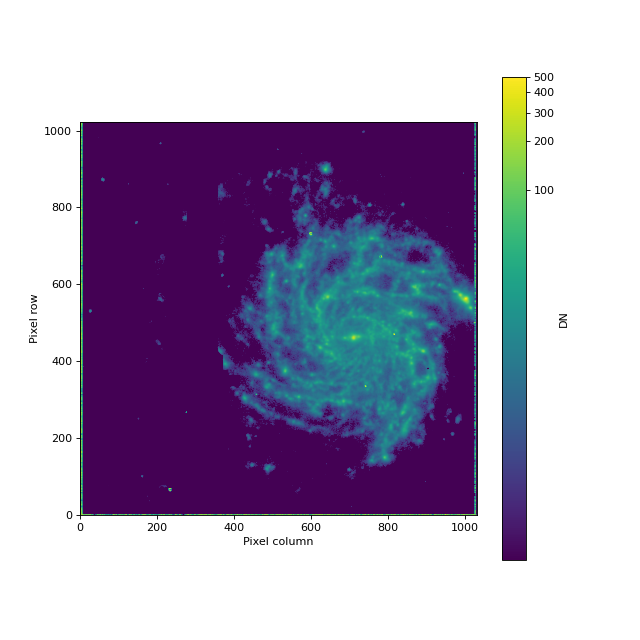

In [13]:
show_image(miri_rate.data, 2, 500)

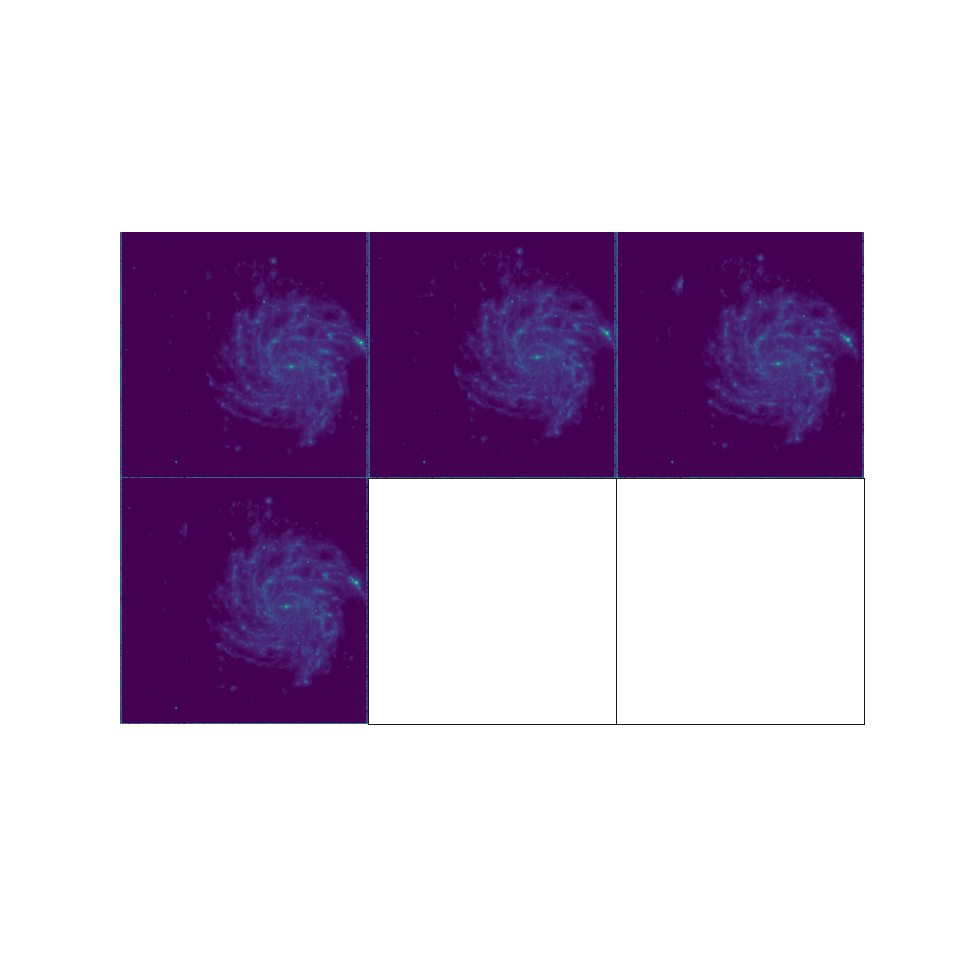

In [14]:
# display the images
fig = plt.figure(1, figsize=(12, 12))
ncols = len(miri_rate_files) // 3
grid = ImageGrid(fig, 111, nrows_ncols=(ncols+1, 3), axes_pad=0)

for i, cfile in enumerate(miri_rate_files):
    with datamodels.open(cfile) as miri_rate:
        cimage = miri_rate.data
        norm_data = simple_norm(cimage, "sqrt", min_cut=2, max_cut=500)
        grid[i].imshow(cimage, norm=norm_data, origin="lower")
        grid[i].axis('off')
        grid[i].set_xticks([])
        grid[i].set_yticks([])

## CALWEBB_IMAGE2

In [15]:
miri_rate_files = glob.glob(f"./stage1/*{filter}exp1_rate.fits")
output_dir = './stage2'
print(miri_rate_files)

['./stage1/det_image_seq1_MIRIMAGE_F770Wexp1_rate.fits', './stage1/det_image_seq2_MIRIMAGE_F770Wexp1_rate.fits', './stage1/det_image_seq3_MIRIMAGE_F770Wexp1_rate.fits', './stage1/det_image_seq4_MIRIMAGE_F770Wexp1_rate.fits']


In [16]:
miri_asn_name = f'miri_{filter}_asn'
miri_asn = asn_from_list.asn_from_list(miri_rate_files, rule=DMSLevel2bBase, product_name=miri_asn_name)

miri_asn_file = f'{miri_asn_name}.json'
with open(miri_asn_file, 'w') as outfile:
    name, serialized = miri_asn.dump(format='json')
    outfile.write(serialized)

In [17]:
# Using the run() method
# Create an instance of the pipeline class
miri_im2 = calwebb_image2.Image2Pipeline()

# Save the pipeline output, and specify the output directory
miri_im2.output_dir = output_dir
miri_im2.save_results = True

# Set any step-related paramters
miri_im2.resample.pixfrac = 1.0

# Call the run() method and provide the MIRI association file as input
miri_im2.run(miri_asn_file)

2022-03-14 14:06:31,762 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2022-03-14 14:06:31,766 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2022-03-14 14:06:31,772 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2022-03-14 14:06:31,776 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2022-03-14 14:06:31,779 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2022-03-14 14:06:31,783 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2022-03-14 14:06:31,913 - stpipe - WARNING - /home/kgordon/Bin/miniconda3/envs/mirisim/lib/python3.9/site-packages/stpipe/step.py:379: ResourceWarning: unclosed file <_io.FileIO name='./stage1/det_image_seq1_MIRIMAGE_F770Wexp1_rate.fits' mode='rb' closefd=True>
  gc.collect()

2022-03-14 14:06:31,925 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('miri_F770W_asn.json',).
2022-03-14 14:06:3

2022-03-14 14:06:32,884 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020381120 -0.015782681 0.022848596 0.015404910 359.991789732 0.017977654 359.988982485 -0.013223759
2022-03-14 14:06:32,885 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2022-03-14 14:06:32,975 - stpipe.Image2Pipeline.assign_wcs - WARNING - /home/kgordon/Bin/miniconda3/envs/mirisim/lib/python3.9/site-packages/astropy/modeling/fitting.py:777: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",

2022-03-14 14:06:33,161 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2022-03-14 14:06:33,296 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from det_image_seq1_MIRIMAGE_F770Wexp1_rate.fits>,).
2022-03-14 14:06:33,300 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'outpu

2022-03-14 14:06:41,220 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from det_image_seq2_MIRIMAGE_F770Wexp1_rate.fits>,).
2022-03-14 14:06:41,224 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2022-03-14 14:06:41,432 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2022-03-14 14:06:41,434 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2022-03-14 14:06:41,435 - stpipe.Image2Pipeline.flat_field 

2022-03-14 14:06:49,246 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2022-03-14 14:06:49,248 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2022-03-14 14:06:49,250 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored
2022-03-14 14:06:49,263 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored
2022-03-14 14:06:49,489 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2022-03-14 14:06:49,638 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from det_image_seq3_MIRIMAGE_F770Wexp1_rate.fits>,).
2022-03-14 14:06:49,642 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are:

2022-03-14 14:06:57,439 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2022-03-14 14:06:57,582 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from det_image_seq4_MIRIMAGE_F770Wexp1_rate.fits>,).
2022-03-14 14:06:57,586 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2022-03-14 14:06:57,650 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_photom_0073.fits
2022-03-14 14:06:57,651 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/kgordon/crds_cache/references/jwst/miri/jwst_miri_area_0004.fits
2022-03-14 14:06:57,803 

[<ImageModel(1024, 1032) from det_image_seq1_MIRIMAGE_F770Wexp1_cal.fits>,
 <ImageModel(1024, 1032) from det_image_seq2_MIRIMAGE_F770Wexp1_cal.fits>,
 <ImageModel(1024, 1032) from det_image_seq3_MIRIMAGE_F770Wexp1_cal.fits>,
 <ImageModel(1024, 1032) from det_image_seq4_MIRIMAGE_F770Wexp1_cal.fits>]

In [18]:
# look at one of the images
miri_cal_files = glob.glob(f"./stage2/*{filter}exp1_cal.fits")
miri_cal = datamodels.open(miri_cal_files[0])

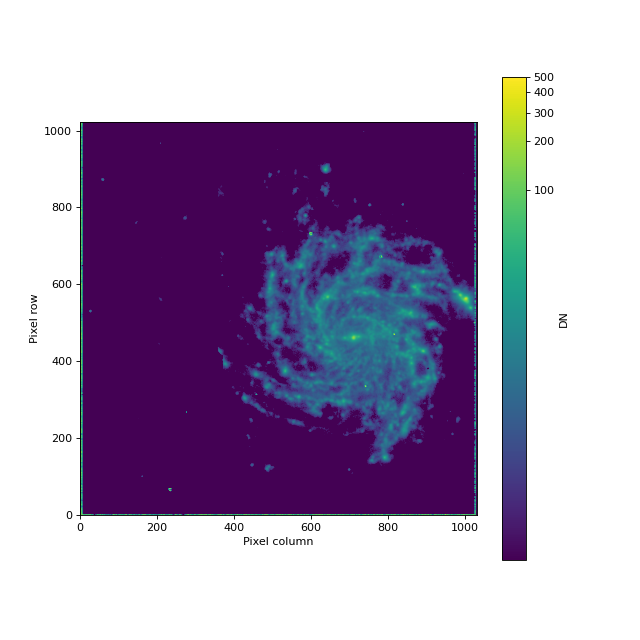

In [19]:
show_image(miri_cal.data, 2, 500)

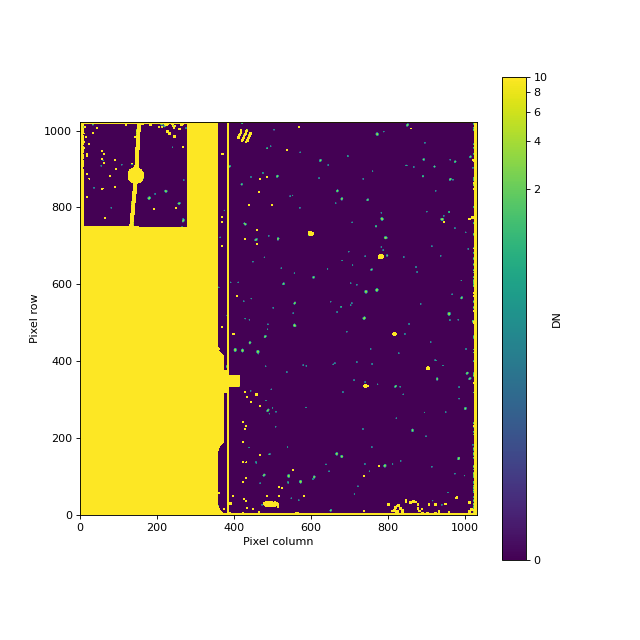

In [20]:
show_image(miri_cal.dq, 0, 10)

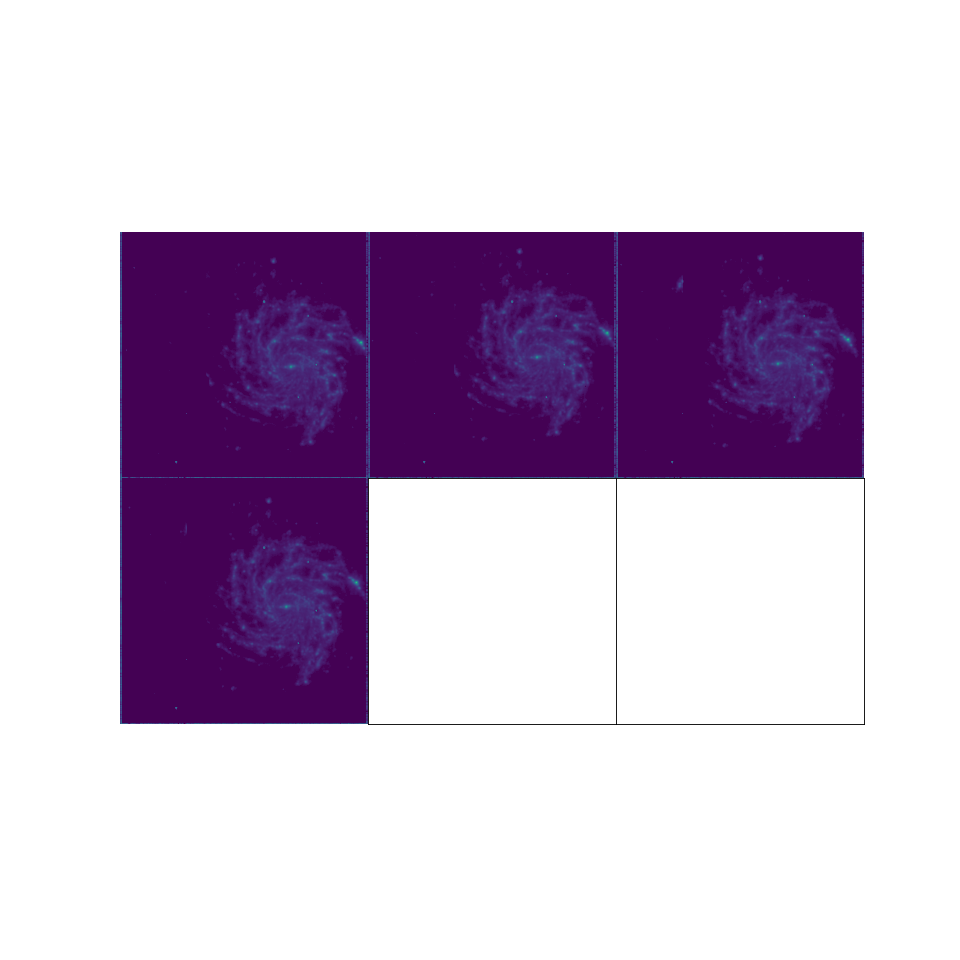

In [21]:
# display the images
fig = plt.figure(1, figsize=(12, 12))
ncols = len(miri_cal_files) // 3
grid = ImageGrid(fig, 111, nrows_ncols=(ncols+1, 3), axes_pad=0)

for i, cfile in enumerate(miri_cal_files):
    with datamodels.open(cfile) as miri_cal:
        cimage = miri_cal.data
        norm_data = simple_norm(cimage, "sqrt", min_cut=2, max_cut=500)
        grid[i].imshow(cimage, norm=norm_data, origin="lower")
        grid[i].axis('off')
        grid[i].set_xticks([])
        grid[i].set_yticks([])

## CALWEBB_IMAGE3

In [22]:
miri_cal_files = glob.glob(f"./stage2/*{filter}exp1_cal.fits")
output_dir = "./stage3/"
print(miri_cal_files)

miri_asn_name = f'miri_{filter}_stage3_asn'
miri_asn = asn_from_list.asn_from_list(miri_cal_files, rule=DMS_Level3_Base, product_name=miri_asn_name)

miri_asn_file = f'{miri_asn_name}.json'
with open(miri_asn_file, 'w') as outfile:
    name, serialized = miri_asn.dump(format='json')
    outfile.write(serialized)

['./stage2/det_image_seq1_MIRIMAGE_F770Wexp1_cal.fits', './stage2/det_image_seq2_MIRIMAGE_F770Wexp1_cal.fits', './stage2/det_image_seq3_MIRIMAGE_F770Wexp1_cal.fits', './stage2/det_image_seq4_MIRIMAGE_F770Wexp1_cal.fits']


In [23]:
# Using the run() method:

# Create an instance of the pipeline class
miri_im3 = calwebb_image3.Image3Pipeline()

# Set the output directory, and specify that you want
# to save the results
miri_im3.output_dir = output_dir
miri_im3.save_results = True

# Set some parameters for individual steps.
# HINT: the PSF FWHM for MIRI with the F700W filter
# is 2.187 pixels.
miri_im3.tweakreg.snr_threshold = 25.0  # 5.0 is the default
miri_im3.tweakreg.kernel_fwhm = 2.187  # 2.5 is the default
miri_im3.tweakreg.brightest = 10  # 100 is the default
miri_im3.source_catalog.kernel_fwhm = 2.187  # pixels
miri_im3.source_catalog.snr_threshold = 10.

# Call the run() method
miri_im3.run(miri_asn_file)

2022-03-14 14:07:07,855 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2022-03-14 14:07:07,861 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2022-03-14 14:07:07,867 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2022-03-14 14:07:07,873 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2022-03-14 14:07:07,879 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2022-03-14 14:07:07,885 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2022-03-14 14:07:07,890 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2022-03-14 14:07:08,062 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('miri_F770W_stage3_asn.json',).
2022-03-14 14:07:08,081 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '

2022-03-14 14:07:15,178 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: det_image_seq2_MIRIMAGE_F770Wexp1_cal' to the reference catalog.
2022-03-14 14:07:15,393 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'det_image_seq2_MIRIMAGE_F770Wexp1_cal' catalog with sources from the reference 'det_image_seq1_MIRIMAGE_F770Wexp1_cal' catalog.
2022-03-14 14:07:15,394 - stpipe.Image3Pipeline.tweakreg - INFO - Computing initial guess for X and Y shifts...
2022-03-14 14:07:15,396 - stpipe.Image3Pipeline.tweakreg - INFO - Found initial X and Y shifts of -1, 0 based on a single non-zero bin and 2 matches
2022-03-14 14:07:15,399 - stpipe.Image3Pipeline.tweakreg - INFO - Found 1 matches for 'GROUP ID: det_image_seq2_MIRIMAGE_F770Wexp1_cal'...
2022-03-14 14:07:15,400 - stpipe.Image3Pipeline.tweakreg - WARNING - Not enough matches (< 1) found for image catalog 'GROUP ID: det_image_seq2_MIRIMAGE_F770Wexp1_cal'.
2022-03-14 14:07:15,402 - stpipe.Image3Pipeline.t

2022-03-14 14:07:33,785 - stpipe.Image3Pipeline.outlier_detection - WARNING - /home/kgordon/Bin/miniconda3/envs/mirisim/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:427: RuntimeWarning: overflow encountered in multiply
  threshold2 = scale2 * blot_deriv + snr2 * err_data

2022-03-14 14:07:33,802 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 21 (0.00%)
2022-03-14 14:07:33,906 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 14 (0.00%)
2022-03-14 14:07:34,016 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 21 (0.00%)
2022-03-14 14:07:34,140 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 33 (0.00%)
2022-03-14 14:07:34,602 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in ./stage3/det_image_seq1_MIRIMAGE_F770Wexp1_a3001_crf.fits
2022-03-14 14:07:35,049 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved

In [24]:
# Look at the resulting mosaic image
miri_mosaic_file = output_dir + miri_asn_name + '_i2d.fits'
miri_catalog_file = output_dir + miri_asn_name + '_cat.ecsv'

In [25]:
# Open the mosaic image
miri_mosaic = datamodels.open(miri_mosaic_file)

In [26]:
# Read in the source catalog
miri_source_cat = ascii.read(miri_catalog_file)

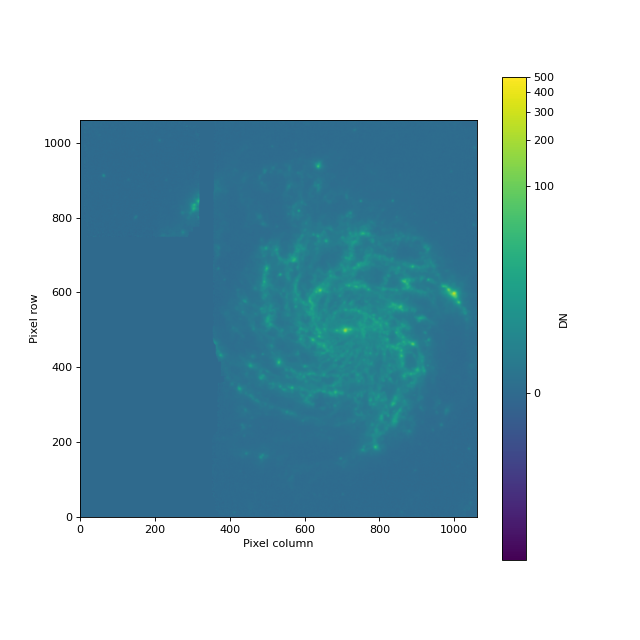

In [27]:
# Look at the mosaic
show_image(miri_mosaic.data, vmin=-5, vmax=500)

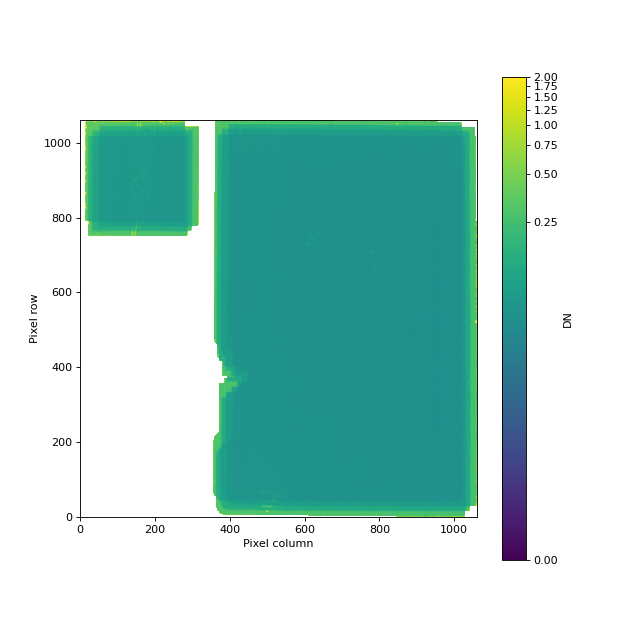

In [28]:
# Look at the mosaic data read noise uncertainties (i.e., coverage map)
show_image(miri_mosaic.var_rnoise, vmin=0.0, vmax=2)

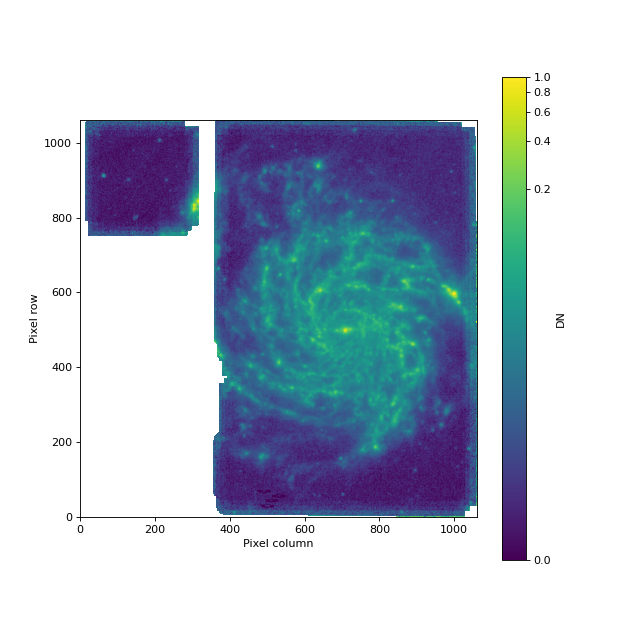

In [29]:
# Look at the mosaic data poisson uncertainties
show_image(miri_mosaic.var_poisson, vmin=0, vmax=1)

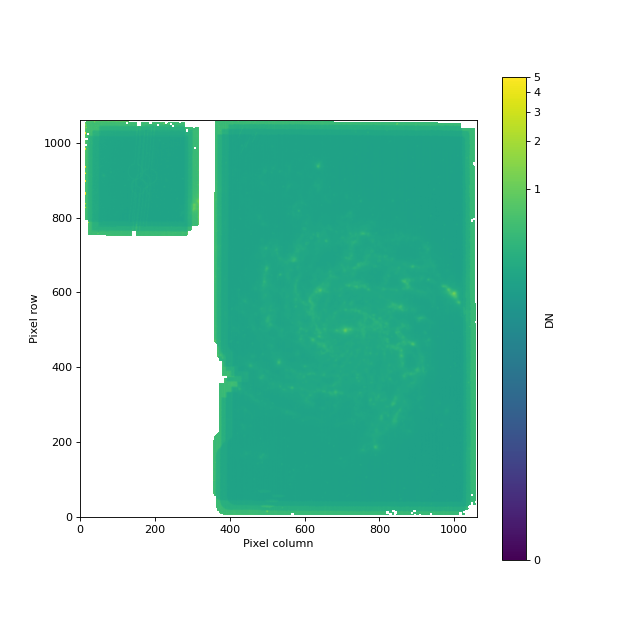

In [30]:
# Look at the mosaic total data uncertainties
show_image(miri_mosaic.err, vmin=0, vmax=5)

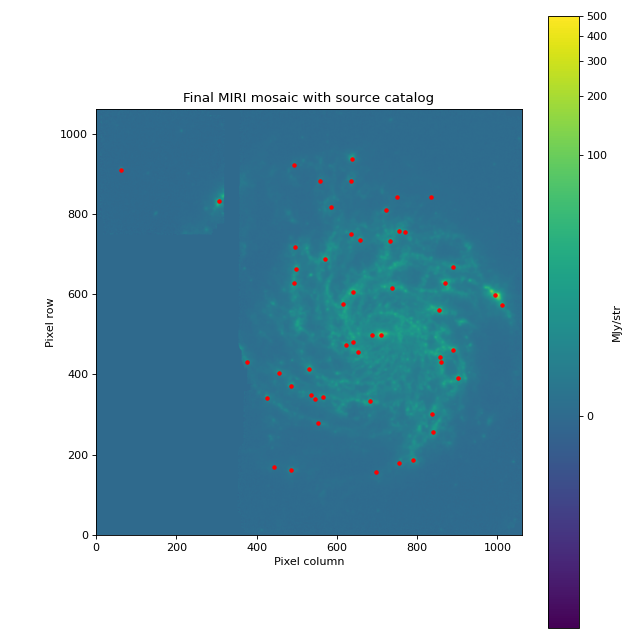

In [31]:
# Show the catalog sources on the mosaic
overlay_catalog(miri_mosaic.data, miri_source_cat, flux_limit=5e-7, vmin=-5, vmax=500,
                title='Final MIRI mosaic with source catalog')